In [87]:
import torch
import numpy as np
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import pandas as pd
import librosa.display
import soundfile as sf

In [120]:
def display_mfcc(mfcc, sr = 22050):
#     mfcc = mfcc.numpy()
    mfcc = mfcc.detach().numpy()
    re_wav = librosa.feature.inverse.mfcc_to_audio(mfcc.T)
    #wav 파형 출력
    librosa.display.waveplot(re_wav, sr=sr, color='r')

In [75]:
class DiabetesDataset(Dataset):
    
    def __init__(self):
#         xy=np.loadtxt('./data/diabetes.csv.gz',delimiter=',',dtype=np.float32)
        x = np.load('최유경_data.npy')
        y = np.load('최유경_label.npy')
        self.len=x.shape[0]
        self.x_data=torch.from_numpy(x).float()
        self.y_data=torch.from_numpy(y).view(-1, 1).float()
        
        
    def __getitem__(self,index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    

In [130]:
batch_size = 32

dataset = DiabetesDataset()

train_loader = DataLoader(dataset = dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=0)

tensor([[-1.0578,  0.4078,  0.3358,  ...,  0.5736,  0.6317, -1.5327],
        [-0.6375,  0.1965, -0.5149,  ...,  0.7544,  0.0209, -0.7433],
        [-0.4237, -0.9078,  1.3690,  ...,  0.6219,  0.9369,  0.8793],
        ...,
        [-0.1579, -1.3580,  1.0610,  ..., -1.1687, -0.2155, -0.8411],
        [ 0.6322, -1.3792,  0.3512,  ..., -1.0608, -1.0619, -0.2152],
        [-0.1251,  0.5286, -0.0722,  ...,  0.7894,  0.6272,  1.5912]])
torch.Size([32, 100])
torch.Size([32, 45])


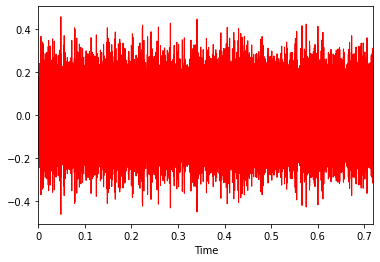

In [161]:
d_noise  = 100
d_hidden = 256

def sample_z(batch_size = 32, d_noise=100):
    return torch.randn(batch_size, d_noise)

G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 45),
    nn.Tanh()
)

# 노이즈 생성하기
z = sample_z()
print(z)
print(z.shape)
# 가짜 이미지 생성하기
img_fake = G(z).view(-1,45)

print(img_fake.shape)
display_mfcc(img_fake)


In [132]:
D = nn.Sequential(
    nn.Linear(45, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([32, 45])
torch.Size([32, 1])
tensor([[0.5116, 0.5125, 0.5071, 0.5066, 0.5091]],
       grad_fn=<TransposeBackward0>)


In [172]:
criterion = nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    
    generator.train()
    discriminator.train()

    for i, data in enumerate(train_loader):
        img_batch, label_batch = data
#         img_batch, label_batch = img_batch.to(device), label_batch.to(device) 

        # ================================================  #
        # maximize V(discriminator,generator) = optimize discriminator (setting k to be 1)  #
        # ================================================  #

        # init optimizer
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1, 45))
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        if loss_real.size() != loss_fake.size():
            continue
        loss_d    = (loss_real + loss_fake).mean()
        
        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + \    #
        #          criterion(p_fake, torch.zeros_like(p_real).to(device))       #
        
        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # ================================================  #
        #        minimize V(discriminator,generator)        #
        # ================================================  #

        
        
        # init optimizer
        _optimizer_g.zero_grad()
        
        

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))
                
        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        
        # instead of: torch.log(1.-p_fake).mean() <- explained in Section 3
        loss_g = -1 * torch.log(p_fake).mean() 

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) #

        loss_g.backward()
       # Update parameters
        _optimizer_g.step()
        
        
#         if i%10==0:
#             print("z" , generator(sample_z(batch_size, d_noise)).shape)
#             display_mfcc(generator(sample_z(batch_size, d_noise)))
        
          
def evaluate_model(generator, discriminator):
    
    p_real, p_fake = 0.,0.
    
    generator.eval()
    discriminator.eval()
        
    for img_batch, label_batch in train_loader:
        
#         img_batch, label_batch = img_batch.to(device), label_batch.to(device) 
        
        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 45))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.
            
            
    return p_real, p_fake

In [173]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = optim.Adam(D.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in range(2):
    
    run_epoch(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)
    
    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake) 
    
#     display_mfcc(torch.Tensor(G(p_fake)))
#     if((epoch+1)% 50 == 0):
    print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
#         imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))

(epoch 1/200) p_real: 4.932600, p_g: 0.003618
(epoch 2/200) p_real: 4.932600, p_g: 0.000528


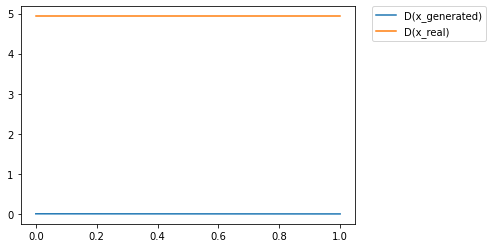

In [174]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()